In [8]:
%matplotlib inline
import datetime
import json
import tldextract
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

In [9]:
with open("BrowserHistory.json") as f:
    data = json.loads(f.read())
    df = pd.DataFrame(data["Browser History"])

In [10]:
df.drop('client_id', axis=1, inplace=True)
df.drop('favicon_url', axis=1, inplace=True)
df.sample(1)

,page_transition,time_usec,title,url
60796,LINK,1492461748117666,Home - Quora,https://www.quora.com/


In [11]:
def convert_time(x):
    return datetime.datetime.fromtimestamp(x/1000000)
df['dt'] = df['time_usec'].apply(convert_time)

In [12]:
def get_date(x):
    return str(x.date())
df['date'] = df['dt'].apply(get_date)

In [13]:
def get_hour(x):
    return int(x.hour)
df['hour'] = df['dt'].apply(get_hour)

In [14]:
def get_month(x):
    return int(x.month)
df['month'] = df['dt'].apply(get_month)

In [15]:
def get_is_secure(x):
    if x.startswith("https"):
        return "Y"
    return "N"
df['is_secure'] = df['url'].apply(get_is_secure)

In [16]:
def get_is_weekend(x):
    if x.weekday() >= 5:
        return "Y"
    return "N"
df['is_weekend'] = df['dt'].apply(get_is_weekend)

In [17]:
days_arr = ["Mon","Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
def get_day_of_week(x):
    return days_arr[x.weekday()]
df['day_of_week'] = df['dt'].apply(get_day_of_week)

In [18]:
def get_domain(x):
    domain = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if sub_domain == "mail":
        return sub_domain + "." + domain
    if domain == "google" and sub_domain=="www":
        return "google_search"
    return domain
df['domain'] = df['url'].apply(get_domain)

In [19]:
def get_category(x):
    if x in ["coursera", "kadenze", "fast", "kaggle"]:
        return "Learning"
    elif x in ["ycombinator", "medium", "hackernoon"]:
        return "TechReads"
    elif x in ["facebook", "twitter", "quora"]:
        return "Social"
    elif x in ["stackoverflow", "superuser"]:
        return "Doubts"
    elif x in ["mail.google", "slack.com"]:
        return "Email"
    elif x in ["flipkart", "amazon", "bigbasket", "myntra"]:
        return "Shopping"
    elif x in ["makemytrip", "goibibo", "cleartrip", "redbus"]:
        return "TravelBookings"
    elif x in ["google_search"]:
        return "Search"
    else:
        return "Other"
df['category'] = df['domain'].apply(get_category)

In [20]:
df = df[(df['page_transition'] == "LINK") | (df['page_transition'] == "TYPED")]
df = df[df['domain'] != 'newtab']

# Secure vs unsecure website visited ratio

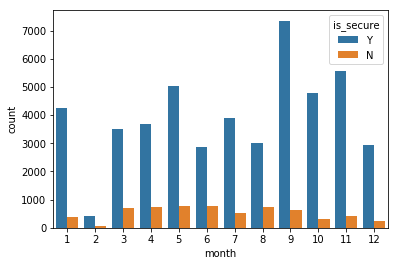

In [21]:
sns.countplot(x="month", hue="is_secure", data=df);

# Weekday vs Weekend browser usage

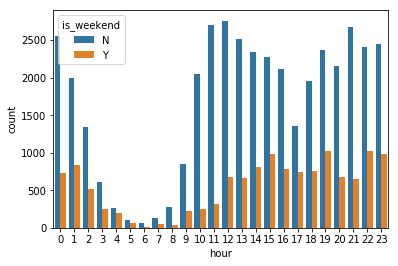

In [22]:
sns.countplot(x="hour", hue="is_weekend", data=df);

# Stackoverflow usage by hour for a month

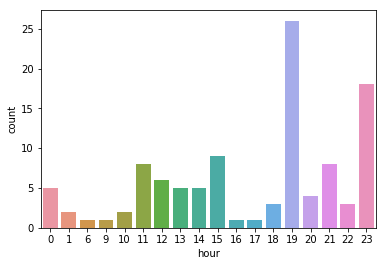

In [23]:
sns.countplot(x="hour", data=df[(df['category'] == "Doubts") & (df["month"] == 11)]);

# Browser usage over months

In [24]:
df_new = df[(df["month"] >= 11)].groupby(["hour", "date"])["domain"].nunique()
df_new = df_new.reset_index(name="count")

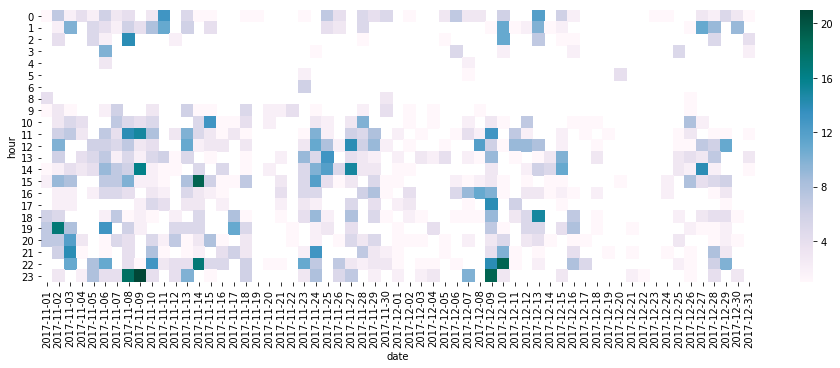

In [25]:
plt.figure(figsize = (16,5))
sns.heatmap(df_new.pivot("hour", "date", "count"), annot=False, cmap="PuBuGn")

# Coursera usage by hour 

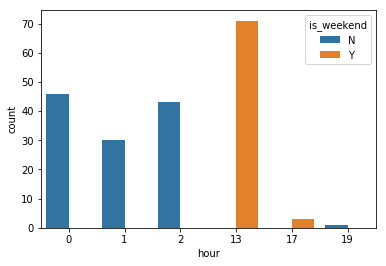

In [26]:
sns.countplot(x="hour", hue="is_weekend", data=df[((df['domain'] == "coursera")) & (df["month"] == 10)]);

# Category visits by month

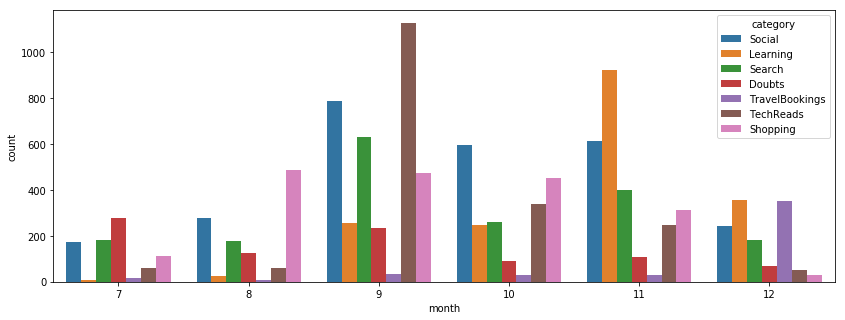

In [27]:
plt.figure(figsize = (14,5))
sns.countplot(x="month", hue="category", data=df[(df['month'] > 6) & (df["category"] != 'Other') & (df["category"] != 'Email')]);

# Category visits by weekday

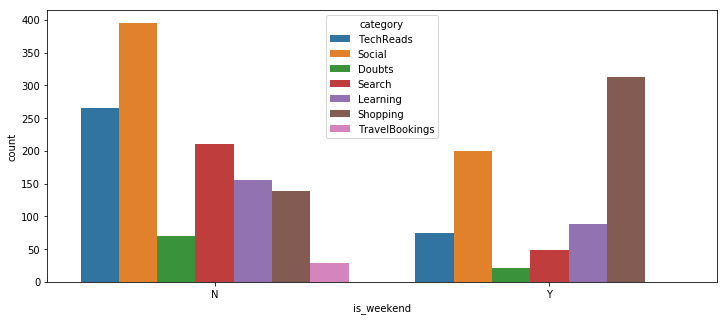

In [28]:
plt.figure(figsize = (12,5))
sns.countplot(x="is_weekend", hue="category", data=df[(df['month'] == 10) & (df["category"] != 'Other') & (df["category"] != 'Email')]);

# Browser visits by day of week and hour

In [29]:
df_heat = df.groupby(["hour", "day_of_week"])["domain"].size().reset_index()
df_heat2 = df_heat.pivot("hour", "day_of_week", "domain")

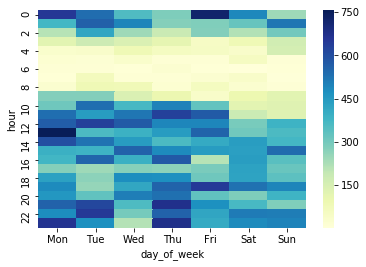

In [30]:
sns.heatmap(df_heat2[days_arr] , cmap="YlGnBu")

# Filtered heatmap by shopping category sites

In [31]:
df_heat = df[df["category"] == "Shopping"].groupby(["hour", "day_of_week"])["category"].size().reset_index()
df_heat2 = df_heat.pivot("hour", "day_of_week", "category")

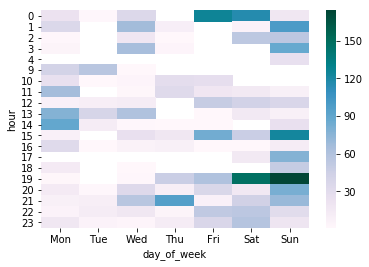

In [32]:
sns.heatmap(df_heat2[days_arr] , cmap="PuBuGn")

# Another useful visualization across all categories

In [33]:
df_cat = df[(df["month"] >= 11)].groupby(["category", "day_of_week", "hour", "domain", "is_weekend"]).size().reset_index()

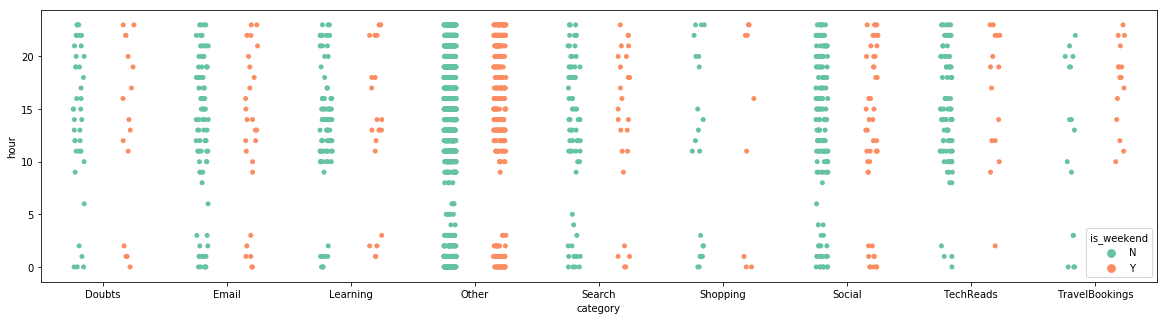

In [34]:
plt.figure(figsize = (20,5))
sns.stripplot(x="category", y="hour", hue="is_weekend",
                    data=df_cat, jitter=True, dodge=True,
                    palette="Set2")

# Most revisited stackoverflow questions

In [35]:
pd.set_option('display.max_colwidth', -1)
df_so = df[df["domain"] == "stackoverflow"].groupby(["url", "title"]).size()
df_so = df_so.reset_index(name='count').sort_values('count',ascending=False)[["title", 'count']]

In [36]:
df_so.head(15)

,title,count
304,python - How to iterate over rows in a DataFrame in Pandas? - Stack Overflow,5
466,python - Label encoding across multiple columns in scikit-learn - Stack Overflow,4
169,Newest Questions - Stack Overflow,4
765,pandas - How can I one hot encode in Python? - Stack Overflow,4
461,python - How do I create test and train samples from one dataframe with pandas? - Stack Overflow,4
0,Stack Overflow,4
647,How to aggregate column values from a CSV file in Python - Stack Overflow,4
551,python 2.7 - How to reshape 4d array to 2d array in numpy - Stack Overflow,3
805,"python - Imitating the ""magic wand"" photoshop tool in OpenCV - Stack Overflow",3
840,python - Pandas dataframe merge on rows - Stack Overflow,3


In [37]:
# # df_google = df[df["domain"] == "google_search"].groupby(["url", "title"]).size()
# df_google = df_google.reset_index(name='count').sort_values('count',ascending=False)[["title", 'count']]

(-0.5, 499.5, 499.5, -0.5)

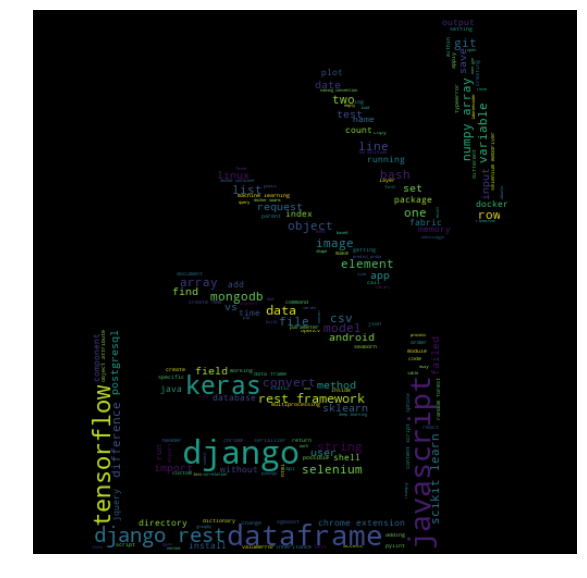

In [38]:
msk = np.array(Image.open("images/mask.png"))
title_concatenated = " ".join(df_so["title"]).lower()
stopwords = set(STOPWORDS)
more_stopwords = set(["error", "class", "file", "pandas", "stack", "column", "columns", "using", "use", "function", "value", "values", "multiple", "stack overflow", "overflow", "python"])
stopwords |= more_stopwords
wordcloud = WordCloud(max_font_size=30, stopwords=stopwords, mask=msk, background_color="black")
wordcloud.generate(title_concatenated)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# References:
* [Chris Albon's notes/tutorials on pandas and data-wrangling](https://chrisalbon.com/#machine_learning) - A must-have on bookmark
* [Seaborn documentation](https://seaborn.pydata.org/tutorial.html)
* [WordCloud Python](https://github.com/amueller/word_cloud)

# Further Ahead:
* [Download Alexa's ranking of website csv(zip)](http://s3.amazonaws.com/alexa-static/top-1m.csv.zip)  could be used to find more insights
* NLTK + KNN clustering to build a throwback machine and suggest similar blogs for re-read, particularly on blogs
